# PHYS20762 - Project - The Damped Harmonic Oscillator

Joseph Bateman<br>
University of Manchester  
February 2021

# The Damped Harmonic Oscillator

Harmonic oscillators are systems which, when subject to displacement from equilibrium, experience a restoring force back towards equilibrium. A simple harmonic oscillator will continue oscillating forever, as no energy is lost from the system. However, with a damped oscillator, a frictional or dissipative force also is present in the system, and as a result energy is lost over time. When this damping is below a critical value, the solution is known analytically, as are the solutions at this critical value and above it. However, when a force is applied to the system, there is no longer an analytic result. Thus, in order to analyse this case, numerical methods must instead be used to solve the problem.

This project seeks to assess the accuracy of a series of numerical integration methods by making comparisons to the analytically solvable case. Then, the most accurate case will be applied to forced oscillations, the properties of which will be examined.

In [1]:
%matplotlib inline

from IPython.display import HTML
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import numpy as np
import time as tm
import string

plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6)

plt.style.use('default')
plt.rcParams["figure.dpi"] = 150

In [2]:
### Defining the parameters describing the system.
M = 3.66 # kg, the mass of object moving in the system
K = 1.85 # kg/s^2 , the spring constant of spring in the system

### Defining the intial conditions of the system.
X_0 = 0.5 # m, the initial position of the system
V_0 = 2 # m/s, the initial velocity of the system


This first section contains the function of each numerical method used to model a spring-mass system. These models will later be compared in accuracy to determine the most appropriate for this problem. Initially the problem is simplified and will not consider the forced aspect of the system. Once the best method has been identified in this simplified case, this will be carried forward and applied to 2 types of forced oscillation, a "push" and a sinusoidal external force.

## Defining the Methods

### Euler Method

In [3]:
def euler(h, b, t):
    nsteps = len(t) # Number of h steps within the set period
    ### Setting the position & velocity arrays, as well as the initial conditions
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = X_0
    v[0] = V_0
    ### Finding position & velocity values for each step, using the previous step conditions
    for i in range(nsteps - 1):
        a = - (K/M)*x[i] - (b/M)*v[i] # Finding the instantaneous acceleration of the mass
        
        x[i+1] = x[i] + h*v[i]
        v[i+1] = v[i] + h*a

    return  x, v

### Improved Euler Method

In [4]:
def improved_euler(h, b, t):
    nsteps = len(t) # Number of h steps within the set period
    ### Setting the position & velocity arrays, as well as the initial conditions
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = X_0
    v[0] = V_0
    ### Finding position & velocity values for each step
    for i in range(nsteps - 1):
        a = - (K/M)*x[i] - (b/M)*v[i] # Finding the instantaneous acceleration of the mass
        x[i+1] = x[i] + h*v[i] + (h**2)*a/2 # Now including a higher order truncation error 
        v[i+1] = v[i] + h*a
    
    return x, v

### Verlet Method

In [5]:
def verlet(h, b, t):
    nsteps = len(t) # Number of h steps within the set period
    ### Setting the position & velocity arrays, as well as the initial conditions    
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = X_0
    v[0] = V_0   
    ### This solution is not self starting, so the Euler-Cromer method is used to find the second terms
    a = - (K/M)*x[0] - (b/M)*v[0]    
    v[1] = v[0] + h*a
    x[1] = x[0] + h*v[1]
    ### Defining constants to be used in Verlet calculations
    C = 2*M + b*h     
    D = 2*(2*M - K*(h**2))/C
    E = (b*h - 2*M)/C
    ### Finding position and velocity values for each step 
    for i in range(nsteps - 2):
        x[i+2] = D*x[i+1] + E*x[i]
        v[i+2] = (D*x[i+2] + E*x[i+1]-x[i+1])/(2*h)

    return x, v

### Euler-Cromer Method

In [6]:
def cromer(h, b, t):
    nsteps = len(t) # Number of h steps within the set period
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = X_0
    v[0] = V_0   
    
    for i in range(nsteps - 1):
        a = - (K/M)*x[i] - (b/M)*v[i]    
        v[i+1] = v[i] + h*a
        x[i+1] = x[i] + h*v[i+1]
        
    return x, v

### Analytic solution
(Where the damping constant is less than the critical value, [see here for more detail](http://farside.ph.utexas.edu/teaching/315/Waves/node10.html "University of Texas"))

In [7]:
def analytic(b, t):   
    ### Determining the analytic solution to the lightly damped harmonic oscillator
    ### Defining the consants due to boundary conditions
    A = (b/(2*1j*np.sqrt(4*K*M-b**2))+1/2)*X_0+V_0*M/(np.sqrt(4*K*M-b**2)*1j) 
    C = X_0-A
    
    ### Defining the angular frequency of the oscillator
    omega = np.sqrt((K/M) - ((b/M)**2)/4) # rad/s
    
    x = np.exp(-b*t/(2*M))*(A*np.exp(1j*omega*t)
                              +C*np.exp(-1j*omega*t))    

    v = -(((A*b/M-2*1j*A*omega)*np.exp(2*1j*omega*t)
           +C*(b/M)+2*1j*C*omega)*np.exp(-((b/M)*t)/2-1j*omega*t))/2
    
    return x,v

## Note on Errors

Despite not utilising or comparing to experimental data, there are still errors in this analysis to account for. 

First of all, there is error due to our model itself. We are assuming an idealised system where the damping and restoring forces behave in a linear manner. However, this will not have an effect on our comparisons going forward, as both the analytic and numerical solutions make this assumption. Yet, if these methods were applied to real experimental data this would have to be accounted for. Furthermore, there would also be an inherent error in the constants of the system as well as the assumption of linearity.

As well as this, there is the most clear error, due to the use of time steps in numerical solutions. As this means position is calculated at discrete points rather than continuously, large step sizes will increase the error of the model, the magnitude of which can be found by making comparisons to the analytic solution. The impact of these errors are amplified by increasing the period of observation. The first part of this project will seek to find a step size that delivers an appropriate level of accuracy over an extended period, while not requiring so many calculations, making the method impractical to use. 

Finally, as the step size is decreased, errors due to python's treatment of floating point numbers will become increasingly impactful. By default, floating point numbers are treated in the double precision format, so a number is accurate to the 16th decimal place. While this will be insignificant for short times (and thus a small amount of steps), as the period increases the number of steps will also increase greatly and this number may have an effect on results. As a result, using appropriate units rather than numbers of large (or very small) order of magnitude is imperative in order to minimise this.

# Plotting the Methods

Following is a plot of each of the methods across a series of step sizes, in order to identify the impact of step size on the accuracy of the function. A very low damping constant has been chosen as this will aid in identifying functions that are not symplectic, ie do not conserve energy. While this will not definitively identify if a function does conserve energy,  functions that show an increase in amplitude over time do not conserve energy, and can be removed from consideration. 

Text(0, 0.5, 'Displacement, m')

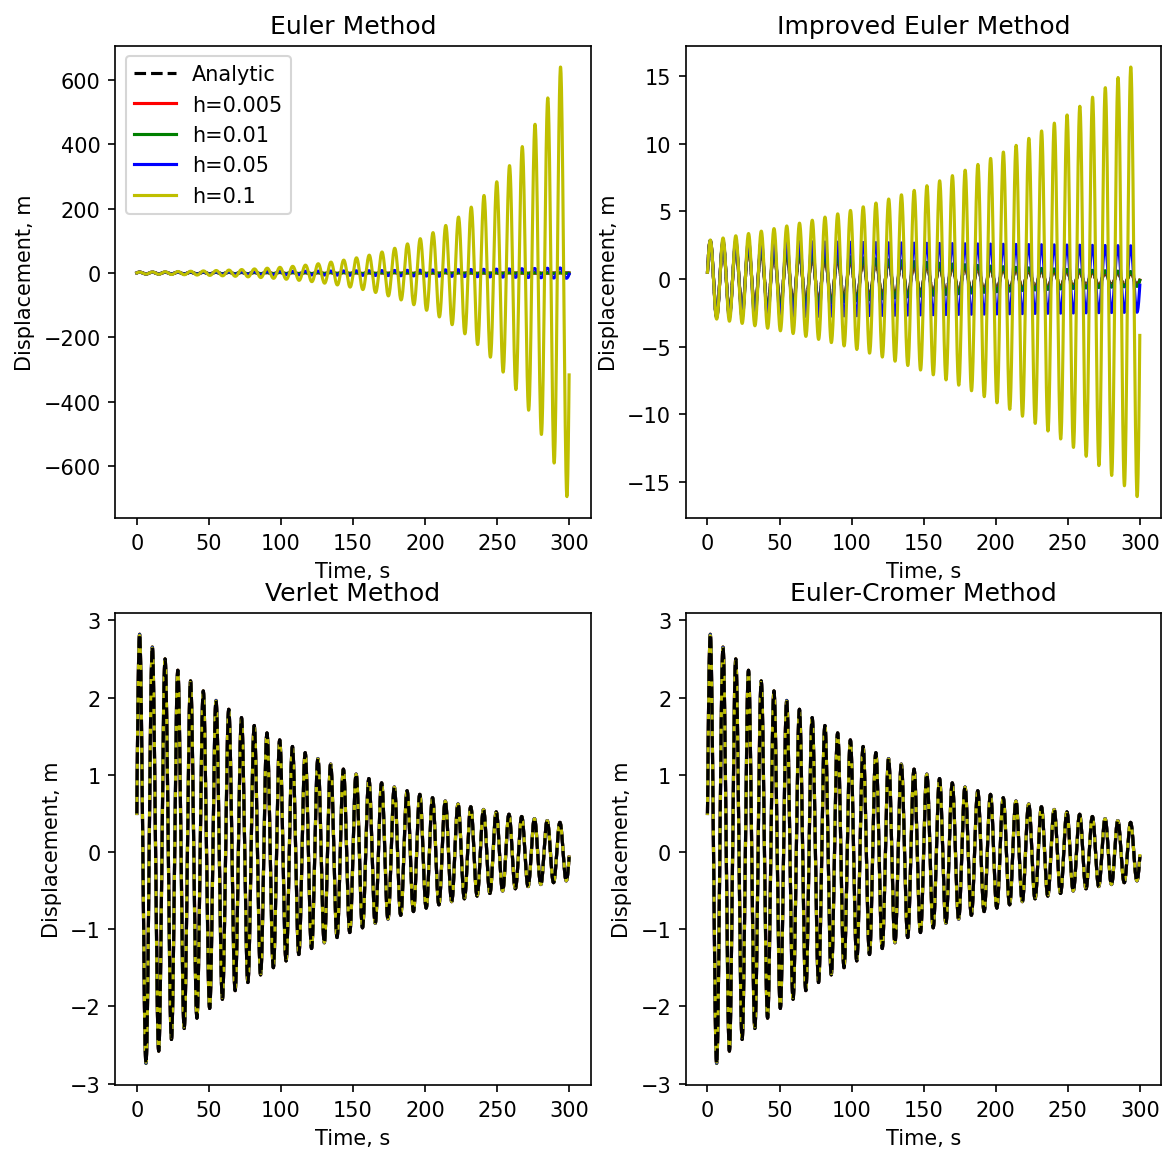

In [8]:
### Setting the initial paramaters to make a cursory assessment of each of the models
T_M = 300 # s, the limit for the time period observed
time_analytic = np.linspace(0,T_M, int(T_M/0.001)) # Creating a very small step array to be used by the analytic function
B = 0.05 # kg/s , the damping constant of the system

# Varying the step size for each function in order to see the effect of change, and whether energy will be conserved.
h_steps = (0.005, 0.01, 0.05, 0.1) 
# Creating an array of formatting types for clarity & consistency
colours = ("r", "g", "b", "y", "c", "m", 
           "tab:pink", "tab:olive", "tab:purple", "tab:orange") 
### Creating a 2x2 set of plots
fig,axs = plt.subplots(2,2)
fig.set_size_inches(9,9)

axs[0, 0].set_title('Euler Method')
axs[0, 0].plot(time_analytic, analytic(B, time_analytic)[0].real, 'k--')
# Iterating the model for each step size
for i, h in enumerate(h_steps):
    time = np.linspace(0,T_M, int(T_M/h))
    axs[0, 0].plot(time, euler(h, B, time)[0], colours[i])
axs[0, 0].set_xlabel("Time, s")
axs[0, 0].set_ylabel("Displacement, m")
axs[0, 0].legend(["Analytic", "h=0.005", "h=0.01", "h=0.05", "h=0.1"])

axs[0, 1].set_title('Improved Euler Method')
axs[0, 1].plot(time_analytic, analytic(B, time_analytic)[0].real, 'k--')
# Iterating the model for each step size
for i, h in enumerate(h_steps):
    time = np.linspace(0,T_M, int(T_M/h))
    axs[0, 1].plot(time, improved_euler(h, B, time)[0], colours[i])
axs[0, 1].set_xlabel("Time, s")
axs[0, 1].set_ylabel("Displacement, m")

axs[1, 0].set_title('Verlet Method')
# Iterating the model for each step size
for i, h in enumerate(h_steps):
    time = np.linspace(0,T_M, int(T_M/h))
    axs[1, 0].plot(time, verlet(h, B, time)[0], colours[i])
axs[1, 0].plot(time_analytic, analytic(B, time_analytic)[0].real, 'k--')
axs[1, 0].set_xlabel("Time, s")
axs[1, 0].set_ylabel("Displacement, m")

axs[1, 1].set_title('Euler-Cromer Method')
# Iterating the model for each step size
for i, h in enumerate(h_steps):
    time = np.linspace(0,T_M, int(T_M/h))
    axs[1, 1].plot(time, cromer(h, B, time)[0], colours[i])
axs[1, 1].plot(time_analytic, analytic(B, time_analytic)[0].real, 'k--')
fig.show
axs[1, 1].set_xlabel("Time, s")
axs[1, 1].set_ylabel("Displacement, m")

As can be seen highlighted in the Euler & Improved Euler methods above, these models do not conserve energy, the effect of which is exacerbated with larger step sizes and a longer time period. Energy conservation is an essential property for a versatile model, as solutions to forced oscillation problems are not analytic so it will be difficult to verify numerical results, and therefore the chosen model must be reliable in many cases. A more in-depth consideration of the energy of the Verlet & Euler-Cromer methods will now be done, as it appears these are both symplectic. The same step sizes will also be used further, as in both cases they resulted in plots that appear very close to the analytic solution.

# Energy Analysis

As has already been indicated in the prior graphs, reducing the step size increases the rate of convergence of these models. However, increasing step size also drastically increases the amount of time for the calculation to finish. Therefore, the model which converges to the analytic solution quickest, as step size is reduced, will be the optimal model to carry out further analysis. 

To do this, the energy the system described by the model is compared to the analytical value across one period at a series of step sizes.

In [9]:
### Defining functions to return an array of instantaneous energyies
def period_energy(func, h, t):
### Finding the energy of the numerical methods
    x, v = func(h, B, t)
    return 1/2 * M * v**2 + 1/2 * K * x**2
def analytic_energy(t):
### Finding the energy of the analytic solution
    x, v = analytic(B, t)
    return 1/2 * M * v.real**2 + 1/2 * K * x.real**2

Text(0, 0.5, 'Energy, J')

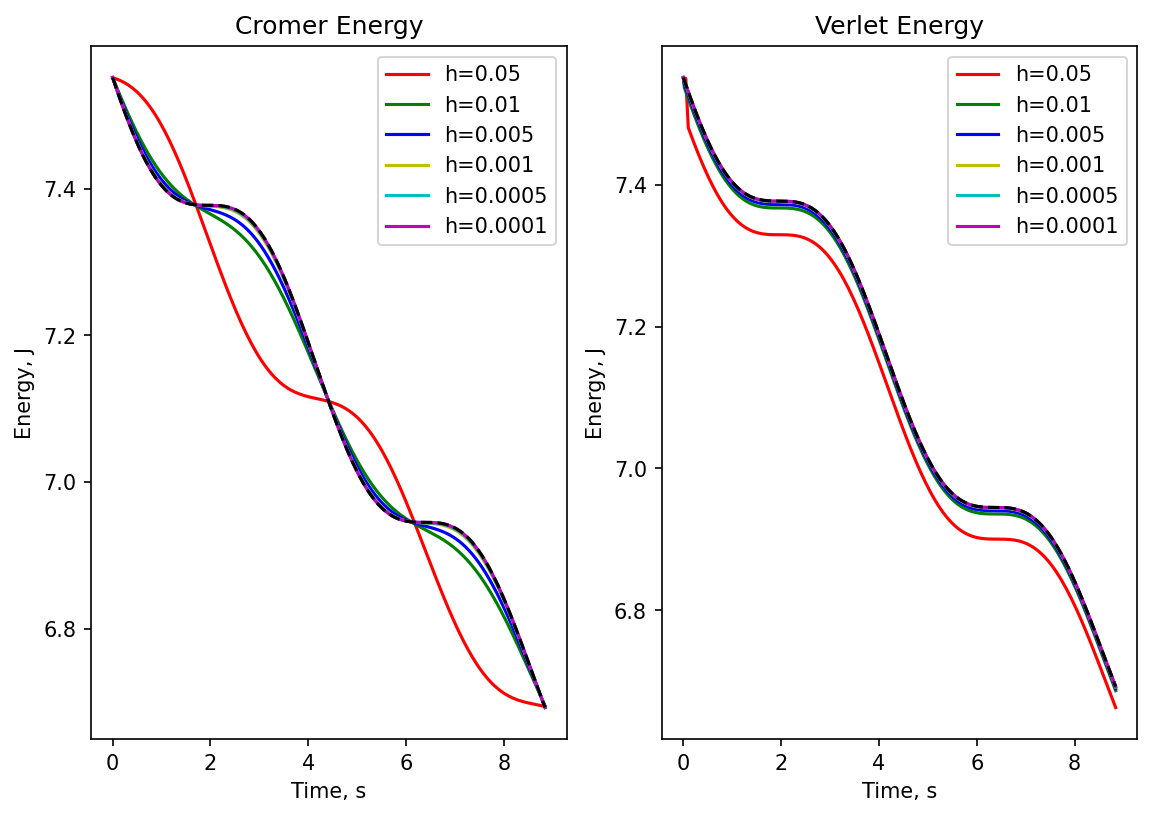

In [10]:
### Resetting initial parameters
h_steps = (0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001)
X_0 = 0.5
V_0 = 2
B = 0.05

ang_freq = np.sqrt(K/M -(B/(2*M))**2) # Defining the angular frequency of the system
period = 2*np.pi/ang_freq # Finding the time for 1 oscillation period to pass 
continuous = np.linspace(0, period, int(period/0.0001)) # Creating a time array that is approximately 
                                                        # continuous for use with the analytic solution.

fig,axs = plt.subplots(1,2)
fig.set_size_inches(9,6)

axs[0].set_title('Cromer Energy')
# Iterating the model for each step size
for i, h in enumerate(h_steps):
    time = np.linspace(0, period, int(period/h))
    axs[0].plot(time, period_energy(cromer, h,time), color=colours[i])
# Plotting the analytic energy
axs[0].plot(continuous, analytic_energy(continuous), 'k--')
axs[0].legend(["h=0.05", "h=0.01", "h=0.005", "h=0.001", "h=0.0005", "h=0.0001"])
axs[0].set_xlabel("Time, s")
axs[0].set_ylabel("Energy, J")

axs[1].set_title('Verlet Energy')
# Iterating the model for each step size
for i, h in enumerate(h_steps):
    time = np.linspace(0, period, int(period/h))
    axs[1].plot(time, period_energy(verlet ,h, time), color=colours[i])
# Plotting the analytic energy
axs[1].plot(continuous, analytic_energy(continuous), 'k--')
axs[1].legend(["h=0.05", "h=0.01", "h=0.005", "h=0.001", "h=0.0005", "h=0.0001"])
axs[1].set_xlabel("Time, s")
axs[1].set_ylabel("Energy, J")

These plots show that at h=0.0005 and 0.0001, there is little appreciable improvement in accuracy over the cycle. As has been mentioned before, very small step sizes begin to introduce computational errors as a result of how the number is stored, truncation error. As very large sets of times will be considered, not only will this take far longer to compute than at slightly larger steps, the magnitude of this truncation error will also increase greatly. As a result, the apparent increased accuracy seen above is outweighed by these other factors, and these step sizes will not be considered further.


For the remaining step values, a mean absolute percentage error of the model will be calculated, across a period of 10 minutes. Such a large period has been chosen to ensure accuracy when extending the time period of forced oscillation to pass the transient period. The model at the largest step size to have a mean deviation of less than 0.1% will be used for the forced oscillation analysis. The time for each mean to be found will also be reported, so comparative assessments can be made about the the practicality of using a very small step size.

In [11]:
def mean_absolute_percentage_error(o, x):
### Defining a function to find the mean absolute percentage error between the analytic and numerical energy vales.
    return np.sum(np.abs(x-o)/np.abs(x))/len(x)

1.841362476348877 s to run Cromer, h=0.001
0.3598921298980713 s to run Cromer, h=0.005
0.17330431938171387 s to run Cromer, h=0.01
0.03554844856262207 s to run Cromer, h=0.05
1.994208812713623 s to run Verlet, h=0.001
0.40813708305358887 s to run Verlet, h=0.005
0.20721936225891113 s to run Verlet, h=0.01
0.03905606269836426 s to run Verlet, h=0.05


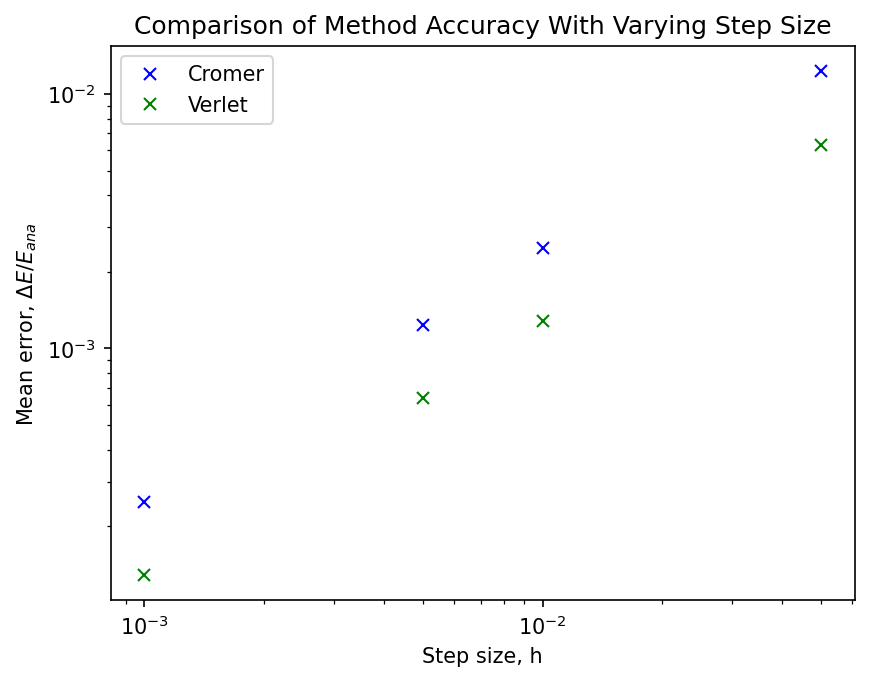

In [12]:
### Resetting initial parameters
h_steps = (0.001, 0.005, 0.01, 0.05)
t = 600
X_0 = 0.5
V_0 = 2
### Creating empty arrays for the mean errors
mean_error_cromer = ([])
mean_error_verlet = ([])

### Determining the mean error for each h value, and measuring the time taken for each method to be completed
for h in h_steps:
    time = np.linspace(0, t, int(t/h))
    start=tm.time()
    mean_error_cromer = np.append(mean_error_cromer, 
                                  mean_absolute_percentage_error(period_energy(cromer, h, time), analytic_energy(time)))
    end=tm.time()
    print(end-start, "s to run Cromer, h={}".format(h))
    
for h in h_steps:
    time = np.linspace(0, t, int(t/h))
    start=tm.time()
    mean_error_verlet = np.append(mean_error_verlet, 
                                  mean_absolute_percentage_error(period_energy(verlet, h, time), analytic_energy(time)))
    end=tm.time()

    print(end-start, "s to run Verlet, h={}".format(h))
                                  
### Configuring a log-log plot to make comparisons about model accuracy at different step sizes       
plt.title("Comparison of Method Accuracy With Varying Step Size")
plt.loglog(h_steps, mean_error_cromer, "bx")
plt.loglog(h_steps, mean_error_verlet, "gx")
plt.xlabel("Step size, h")
plt.ylabel("Mean error, $\Delta E/E_{ana}$")
plt.legend(["Cromer", "Verlet"])

Using these results, it is clear the h=0.001 methods are extremely accurate in both cases, each meeting the requirements given. However, both these functions take about 2 seconds to complete a 600 second run, significantly longer than the h=0.005 cases, which took around 0.4 seconds to finish. Furthermore, at these initial conditions the h=0.005 Verlet method also has a mean absolute percentage error of 0.00096, meeting the 99.9% criteria. While the Euler-Cromer method is almost as accurate at this step and is in fact slightly faster, this difference in time will be negligible when compared to other functions being used, such as plotting, so the accuracy of Verlet is more preferable. As a result, the Verlet method at h=0.005 will be used further, as it appears to be the optimal balance of accuracy and speed.

# Effects of Damping on an Oscillating System

Now a model has been chosen to solve the this differential equation numerically, we will now use it to find the solutions at $B$ = $\frac{B_{CR}}{2}$ , $B_{CR}$, and $2B_{CR}$. The critical value for damping is found using $B_{CR}^2 = 4km$. The initial conditions have been changed such that t=0 corresponds to the peak of the curve, x=2 m. 

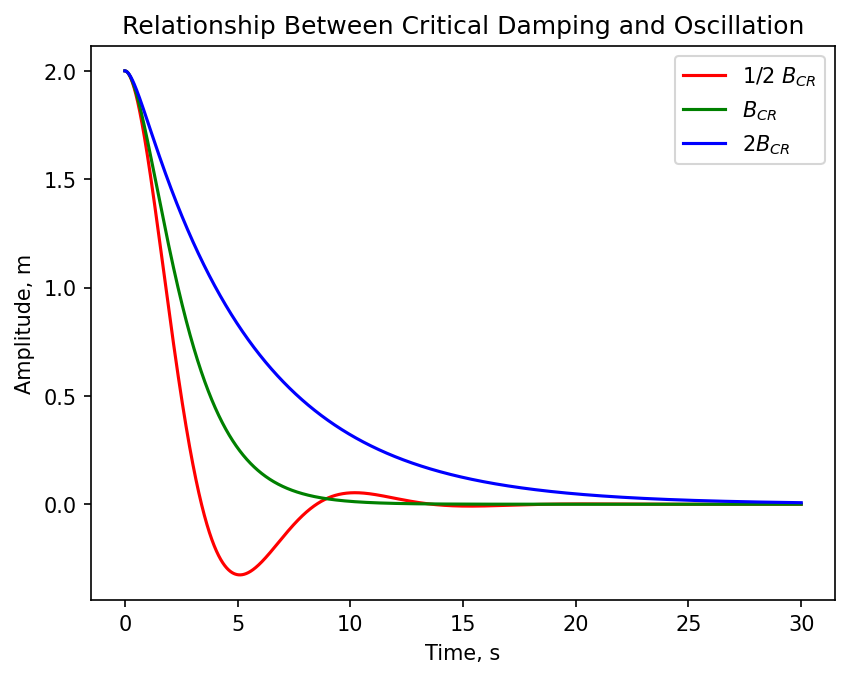

In [13]:
### Resetting initial parameters
h = 0.005
X_0 = 2 # These parameters have been changed so the effect of damping on a mass starting from the same point can
V_0 = 0 # be observed, as having an initial veloicty would mean the peak of each curve would be a different point.
time = np.linspace(0,30, int(30/h))
B_CR = np.sqrt(4*K*M) # kg/s, the critical damping value for the system

### Creating position/velocity arrays using the verlet method at the previously outlined B values
half_critical = verlet(h, B_CR/2, time)
critical = verlet(h, B_CR, time)
two_critical = verlet(h, 2*B_CR, time)

### Formatting the plot of superimposed curves for comparison
plt.title("Relationship Between Critical Damping and Oscillation")
plt.plot(time, half_critical[0], colours[0])
plt.plot(time, critical[0], colours[1])
plt.plot(time, two_critical[0], colours[2])
plt.xlabel("Time, s")
plt.ylabel("Amplitude, m")
plt.legend(["1/2 $B_{CR}$", "$B_{CR}$", "$2B_{CR}$"])

As can be seen above, damping less than what is critical for the system will result in the oscillation of the system before all the energy is dissipated, and a damping value greater than critical will result in the dissipation of all energy from the system before a single oscillation is complete. The critical value represents the turning point from a slight oscillation to a slow decay of energy, and is the value that will dissipate energy quickest from the system. As can be seen above, damping less than what is critical for the system will result in the oscillation of the system before all the energy is dissipated, and a damping value greater than critical will result in the dissipation of all energy from the system before a single oscillation is complete. The critical value represents the turning point from a slight oscillation to a slow decay of energy, and is the value that will dissipate energy quickest from the system.

# Forced Oscillation of a Damped Harmonic System

Unlike a freely oscillating damped harmonic system, one that is forced to oscillate is not solvable analytically and as such must be solved using numerical methods. Now the model and step size has been chosen, this more complex system will be analysed in three different cases: 

1. A "Push" force. 
2. A sinusoidal driving force.
3. Drag forces acting on the mass.

First of all, the Verlet method must be updated to include acceleration due an external force into the calculations, and the updated form can be seen below.

In [14]:
### Defining the Verlet method to include an external force, and taking initial conditions as arguements for convenience
def forced_verlet(h, b, f, x0, v0, t):
    nsteps = len(t) # Number of h steps within the set period
    ### Defining the position & velocity arrays, as well as initial conditions
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x0 # These are now variables of the function, so a series of applied forces can be found
    v[0] = v0 # by chaining the functions together. 
    
    ### This solution is not self starting, so the Euler-Cromer method is used to find the second term
    a = - (K/M)*x[0] - (b/M)*v[0] + f[0]/M       
    v[1] = v[0] + h*a
    x[1] = x[0] + h*v[1]
    
    ### The constants for this function are defined, and the verlet method is applied for the time period
    C = 2*M + b*h     
    D = 2*(2*M - K*(h**2))/C
    E = (b*h - 2*M)/C
    F = (2*(h**2))/C
    for i in range(nsteps - 2):
        x[i+2] = D*x[i+1] + E*x[i] + F*f[i+1]
        v[i+2] = (D*x[i+2] + E*x[i+1] + F*f[i+2] - x[i+1])/(2*h)

    return x, v

# Case (A):  "Push" Force

For this case,  an external "push" is applied for a short period to the system after a few oscillations. The direction and time at which it is applied at will be varied and the effect on the system shown.

In [15]:
### Defining a fuction to apply a force to an oscillator for set periods of time. t is an array, which contains the time
### periods corresponding to time for; no push, push, no push, push etc. This means any number of pushes can be applied
### to the system.
def push_function(t, B, f, X0, V0):
    ### Finding the position and velocity values for the initial, unforced period
    pos, vel = forced_verlet(h, B, np.zeros(int(t[0]/h)), X0, V0, np.linspace(0, t[0], int(t[0]/h)))
    
    for i in range(len(t)-1):
            x0, v0 = pos[-1], vel[-1] # The final values of the previous period are used for the next
                                      # period's initial conditions
            ### Odd indices of the time array correspond to push periods, which are then calculated
            if i+1 & 1:
                X = forced_verlet(h, B, np.full(int(t[i+1]/h),f), x0, v0, np.linspace(0, t[i+1], int(t[i+1]/h)))
                pos = np.append(pos, X[0])
                vel = np.append(vel, X[1])
            ### Even indices are unforced periods, calculated here
            else:
                X = forced_verlet(h, B, np.zeros(int(t[i+1]/h)), x0, v0, np.linspace(0, t[i+1], int(t[i+1]/h)))
                pos = np.append(pos, X[0])
                vel = np.append(vel, X[1])
    ### The total time is calculated and returned with the complete position and velocity data.
    time = np.linspace(0, np.sum(t),int(np.sum(t)/h))
    return pos, vel, time

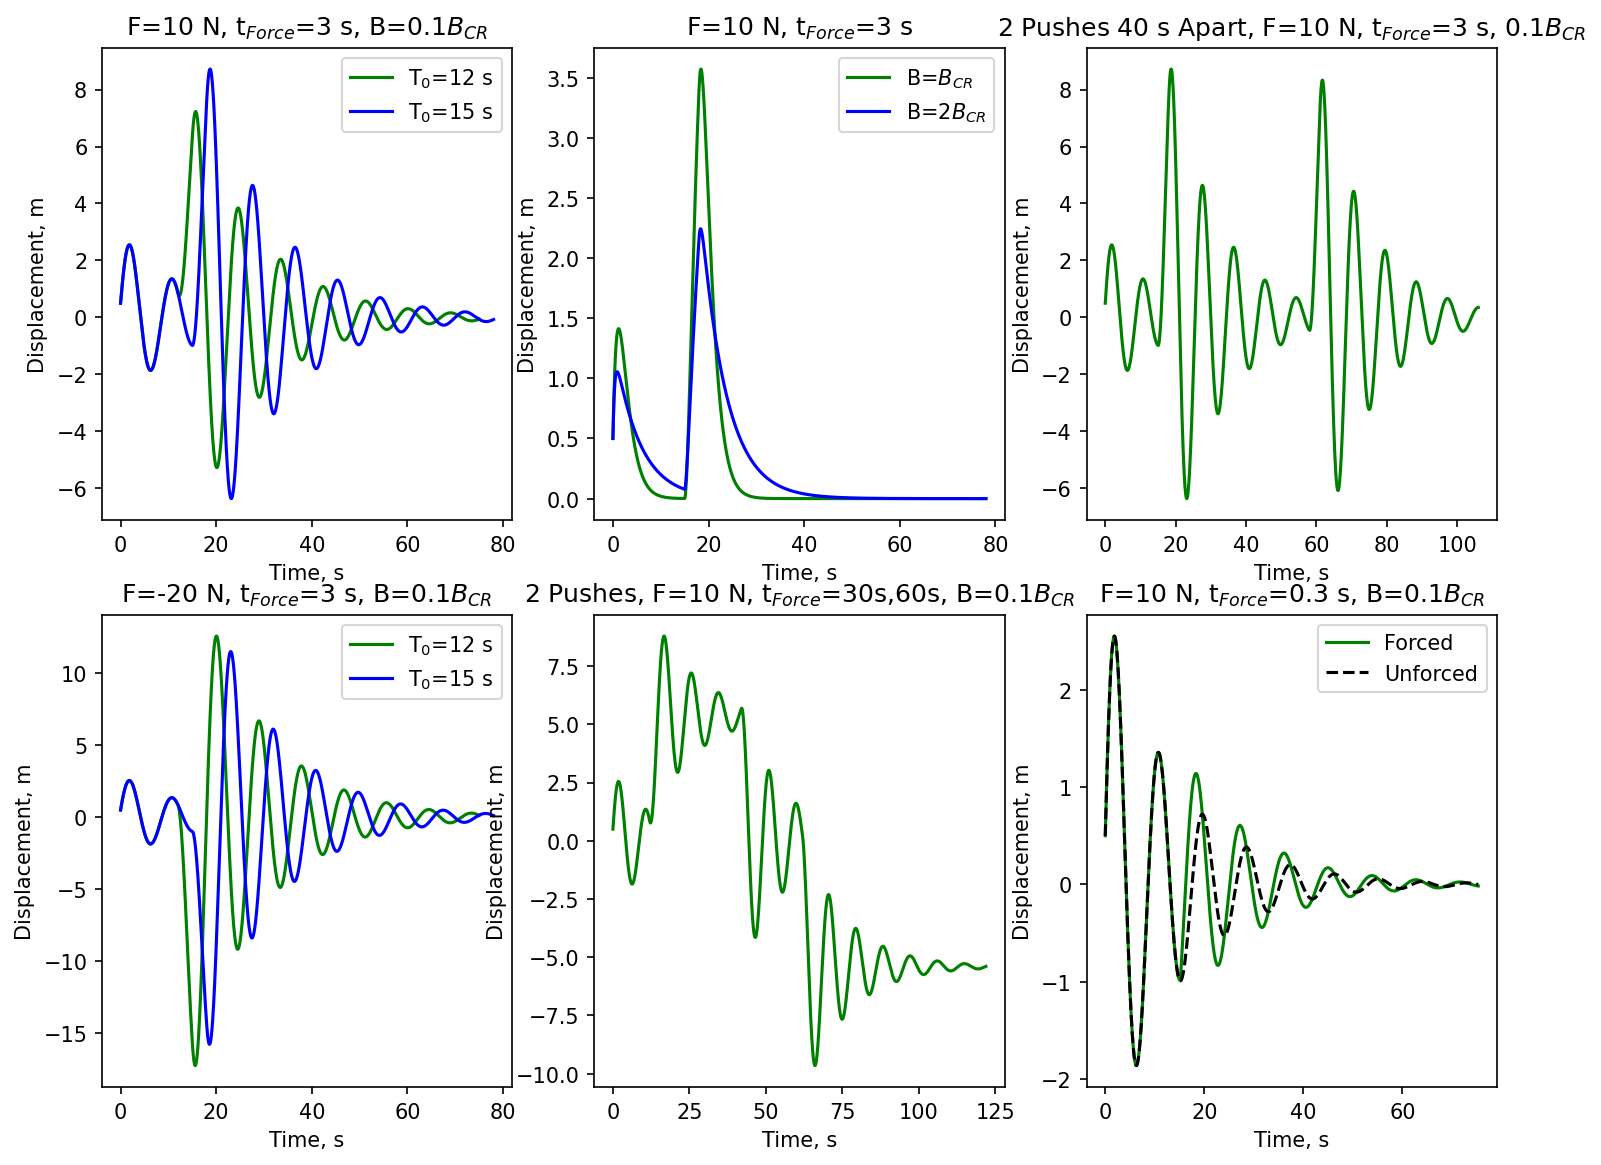

In [16]:
h = 0.005
F = 10 # N, magnitude of force to be applied
### Setting initial periods
X_0 = 0.5 # m, the initial position of the system
V_0 = 2 # m/s, the initial velocity of the system
T_0 = 15 # s, time passing before push
T_F = 3 # s, time push is applied for
T_1 = 60 # s, time after push to be observed
times = ([T_0, T_F, T_1]) # Initial time array, coresponding to a singular push

### Creating a 3x2 set of plots
fig,axs = plt.subplots(2,3)
fig.set_size_inches(12, 9)

### Plot comparing the application of 10 N for 3s at different points in the cycle
axs[0, 0].set_title('F=10 N, t$_{Force}$=3 s, B=0.1$B_{CR}$')
pos, vel, time = push_function(([12, T_F, T_1]), 0.1*B_CR, F, X_0, V_0)
axs[0, 0].plot(time, pos, 'g')
pos, vel, time = push_function(times, 0.1*B_CR, F, X_0, V_0)
axs[0, 0].plot(time, pos, 'b')
axs[0, 0].set_xlabel("Time, s")
axs[0, 0].set_ylabel("Displacement, m")
axs[0, 0].legend(["T$_0$=12 s", "T$_0$=15 s"])

### Plot comparing the impact of a push on a critically damped & overdamped system
axs[0, 1].set_title('F=10 N, t$_{Force}$=3 s')
pos, vel, time = push_function(times, B_CR, F, X_0, V_0)
axs[0, 1].plot(time, pos, 'g')
pos, vel, time = push_function(times, 2*B_CR, F, X_0, V_0)
axs[0, 1].plot(time, pos, 'b')
axs[0, 1].set_xlabel("Time, s")
axs[0, 1].set_ylabel("Displacement, m")
axs[0, 1].legend(["B=$B_{CR}$", "B=2$B_{CR}$"])

### Plot showing the impact of applying subsequent pushes, with a gap of 40 seconds
axs[0, 2].set_title('2 Pushes 40 s Apart, F=10 N, t$_{Force}$=3 s, 0.1$B_{CR}$')
pos, vel, time = push_function(([15,3,40,3,45]), 0.1*B_CR, F, X_0, V_0)
axs[0, 2].plot(time, pos, 'g')
axs[0, 2].set_xlabel("Time, s")
axs[0, 2].set_ylabel("Displacement, m")

### Plot showing the impact of increasing the magnitude of the applied force, as well as inversing the direction
### This situation is identical to the first plot, except for the magnitude and direction of the force
axs[1, 0].set_title('F=-20 N, t$_{Force}$=3 s, B=0.1$B_{CR}$')
pos, vel, time = push_function(([12, T_F, T_1]), 0.1*B_CR, -2*F, X_0, V_0)
axs[1, 0].plot(time, pos, 'g')
pos, vel, time = push_function(times, 0.1*B_CR, -2*F, X_0, V_0)
axs[1, 0].plot(time, pos, 'b')
axs[1, 0].set_xlabel("Time, s")
axs[1, 0].set_ylabel("Displacement, m")
axs[1, 0].legend(["T$_0$=12 s", "T$_0$=15 s"])

### Plot showing the effect of applying a push for an extended period of time first for 30 s and then 60 s
axs[1, 1].set_title('2 Pushes, F=10 N, t$_{Force}$=30s,60s, B=0.1$B_{CR}$')
pos1, vel1, time1 = push_function(([12, 30, 10]), 0.1*B_CR, F, X_0, V_0)
pos2, vel2, time2 = push_function(([10, 60]), 0.1*B_CR, -F, pos1[-1], vel1[-1])
pos = np.append(pos1, pos2)
time = np.linspace(0, (np.max(time1)+np.max(time2)), int((np.max(time1)+np.max(time2))/h))
axs[1, 1].plot(time, pos, 'g')
axs[1, 1].set_xlabel("Time, s")
axs[1, 1].set_ylabel("Displacement, m")

### Plot showing the impact of applying a force for a short period of time
axs[1, 2].set_title('F=10 N, t$_{Force}$=0.3 s, B=0.1$B_{CR}$')
pos, vel, time = push_function(([T_0, 0.3, T_1]), 0.1*B_CR, F, X_0, V_0)
axs[1, 2].plot(time, pos, 'g')
axs[1, 2].plot(time, analytic(0.1*B_CR, time)[0].real, 'k--')
axs[1, 2].set_xlabel("Time, s")
axs[1, 2].set_ylabel("Displacement, m")
axs[1, 2].legend(["Forced", "Unforced"])

The graphs above show the effect applying a push force to an oscillating system for different lengths of time, and at different points in the curve. For short application times, ie 3 seconds, the force acts to "restart" the oscillation cycle, increasing the amplitude with a larger magnitude. However, if the impulse is too small, ie applying the force for too short a period, the oscillation is nearly indistinguishable from an unforced oscillator. What is also apparent is that the new amplitude due to the push is dependent on when the force is applied at within an oscillation. The impact of this will be examined further in the next section.

More interestingly is behaviour when the push is held for a long period of time. It appears the push moves the equilibrium point of the system to an amplitude dependent on the force applied.  The oscillator will then decay about this new equilibrium point until the force is released, at which point it returns to oscillating about x=0 m. 

## Impact of a "Push" at Different Points in an Oscillation.

Text(0, 0.5, 'Amplitude, m')

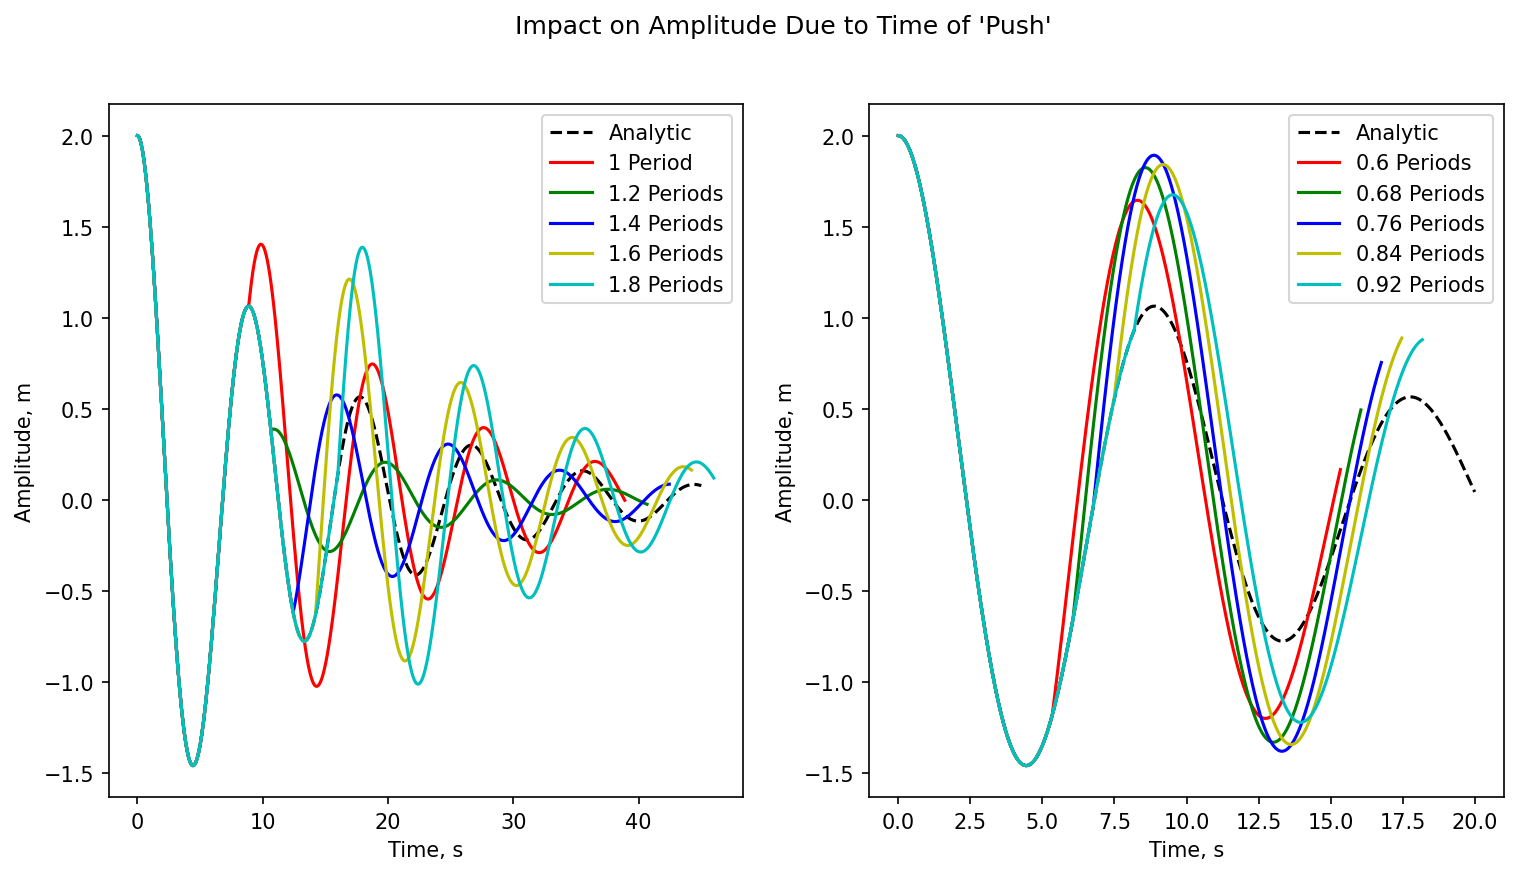

In [17]:
h = 0.005
B = 0.1*B_CR
F = 500 # N, force applied to the system
### Setting initial periods
X_0 = 2 # m, the initial position of the system
V_0 = 0 # m/s, the initial velocity of the system

### Creating a series of coefficients to set when in the period the force is applied.
coeffs_1 = np.linspace(1,2,5, endpoint=False)
coeffs_2 = np.linspace(0.6,1,5, endpoint=False)
### Setting the initial time parameters 
T_F = 3 # s, time push is applied for
T_1 = 30 # s, time after push to be observed
ang_freq = np.sqrt(K/M -(B/(2*M))**2) # Defining the angular frequency of the system
period = 2*np.pi/ang_freq # Finding the time for 1 oscillation to pass 

### Setting up a 1x2 plot
fig,axs = plt.subplots(1,2)
fig.set_size_inches(12, 6)
fig.suptitle("Impact on Amplitude Due to Time of 'Push'")

### Plotting the impact of a short period, high magnitude force at differnt points of the oscillation
axs[0].plot(np.arange(0,45,0.001), analytic(B, np.arange(0,45,0.001))[0].real, "k--")
for i, value in enumerate(coeffs_1):
    pos, vel, time = push_function(([value*period, 0.01, T_1]), 0.1*B_CR, F, X_0, V_0)
    axs[0].plot(time, pos, colours[i])
axs[0].legend(["Analytic", "1 Period", "1.2 Periods", "1.4 Periods", "1.6 Periods", "1.8 Periods"])

axs[0].set_xlabel("Time, s")
axs[0].set_ylabel("Amplitude, m")

### Plotting the impact of a short period, high magnitude force about the optimal point of the oscillation
axs[1].plot(np.arange(0,20,0.001), analytic(B, np.arange(0,20,0.001))[0].real, "k--")
for i, value in enumerate(coeffs_2):
    pos, vel, time = push_function(([value*period, 0.01, 10]), 0.1*B_CR, F, X_0, V_0)
    axs[1].plot(time, pos, colours[i])
axs[1].legend(["Analytic", "0.6 Periods", "0.68 Periods", "0.76 Periods", "0.84 Periods", "0.92 Periods"])
axs[1].set_xlabel("Time, s")
axs[1].set_ylabel("Amplitude, m")

For these graphs, the mass was released from at x=2 m with no initial velocity, and left initially for 1 oscillation. In the left hand case, a 500 N upward force was applied for 0.01 seconds at a series of points throughout the cycle. The large force over a small period was chosen to increase the separation between peaks for clarity, and to approximate an instantaneous force as much as possible. From the resulting graph, it appears that the greatest amplitudes occur when the velocity and force are in the same direction.

The second graph focuses on the second part of the oscillation where the maxima appears to be located. The optimal time to apply a force in this case is approximately 3/4 of the way through a period, when the mass is at the equilibrium position and velocity is in the same direction as the force. This is what we would expect as there is no restoring force acting upon the mass at this point in time, so there is no opposing deceleration taking place.

## Visulising This Push

To more clearly visualise how the variation in push timing would impact oscillation, the times between 0.6 and 1 period will be animated.

In [18]:
def drawframe_push(n):
### Function defining the position of each oscillator in each frame    
    y1 = pos_1[n]
    y2 = pos_2[n]
    y3 = pos_3[n]
    y4 = pos_4[n]
    y5 = pos_5[n]
    y6 = pos_6[n]
        
    line1.set_data(np.linspace(0.5,0.6,2), y1)
    line2.set_data(np.linspace(0.7,0.8,2), y2)
    line3.set_data(np.linspace(0.9,1,2), y3)
    line4.set_data(np.linspace(1.1,1.2,2), y4)
    line5.set_data(np.linspace(1.3,1.4,2), y5)
    line6.set_data(np.linspace(1.5,1.6,2), y6)

    return (line1),(line2),(line3),(line4),(line5),(line6),

In [19]:
%%capture
h = 0.005
B = 0.1*B_CR
F = 500 # N, force applied to the system
### Setting initial periods
X_0 = 2 # m, the initial position of the system
V_0 = 0 # m/s, the initial velocity of the system

### Creating a figure & defining the limits
fig = plt.figure()
ax = plt.subplot(1,1,1) 
ax.set_xlim(0,2)
ax.set_ylim(-2,2)
ax.set_xlabel("Oscillator Position, m")
ax.set_ylabel("Displacement, m")
ax.set_title("Impact on Amplitude Due to Time of 'Push'")

### Defining the components for each of the oscillators
line1, = ax.plot([], [], colours[0], lw=2) 
line2, = ax.plot([], [], colours[1], lw=2)
line3, = ax.plot([], [], colours[2], lw=2)
line4, = ax.plot([], [], colours[3], lw=2)
line5, = ax.plot([], [], colours[4], lw=2)
line6, = ax.plot([], [], colours[5], lw=2)

### Creating position arrays for each oscillator - only 1 in 10 position values
ana_time = np.linspace(0, np.sum(period + 0.01 + 25),int(np.sum(period + 0.01 + 25)/h))[::15]
pos_1 = push_function(([0.6*period, 0.01, (25 + 0.4*period+h)]), 0.1*B_CR, F, X_0, V_0)[0][::15]
pos_2 = push_function(([0.68*period, 0.01, (25+ 0.32*period)]), 0.1*B_CR, F, X_0, V_0)[0][::15]
pos_3 = push_function(([0.76*period, 0.01, (25 + 0.24*period)]), 0.1*B_CR, F, X_0, V_0)[0][::15]
pos_4 = push_function(([0.84*period, 0.01, (25+ 0.16*period)]), 0.1*B_CR, F, X_0, V_0)[0][::15]
pos_5 = push_function(([0.92*period, 0.01, (25+ 0.08*period)]), 0.1*B_CR, F, X_0, V_0)[0][::15]
pos_6 = analytic(B, ana_time)[0].real
fig.legend(["0.6 Periods", "0.68 Periods", "0.76 Periods", "0.84 Periods", "0.92 Periods", "Analytic"])

anim = animation.FuncAnimation(fig, drawframe_push, frames=len(ana_time), interval=20, blit=True)

In [20]:
### Rendering the animation
rc('animation', html='html5')
anim

# Case (B): A Sinusoidal Force

The force applied in this case will be sinusoidal, with a frequency different to the undamped natural frequency, $\omega_0$ = $\sqrt{\frac{k}{m}}$, and comparisons will be made to the unforced oscillatory case. The resonance of this system will then be examined, at differing damping values and as the angular frequency approaches $\omega_r$. 

In [21]:
def sin_force(f, ang_freq, time):
    ### Defining the driving force in this case, a sin function with amplitude f
    return np.sin(time*ang_freq) * f

## Effect of $\omega$ Values on Oscillation

Text(0, 0.5, 'Displacement, m')

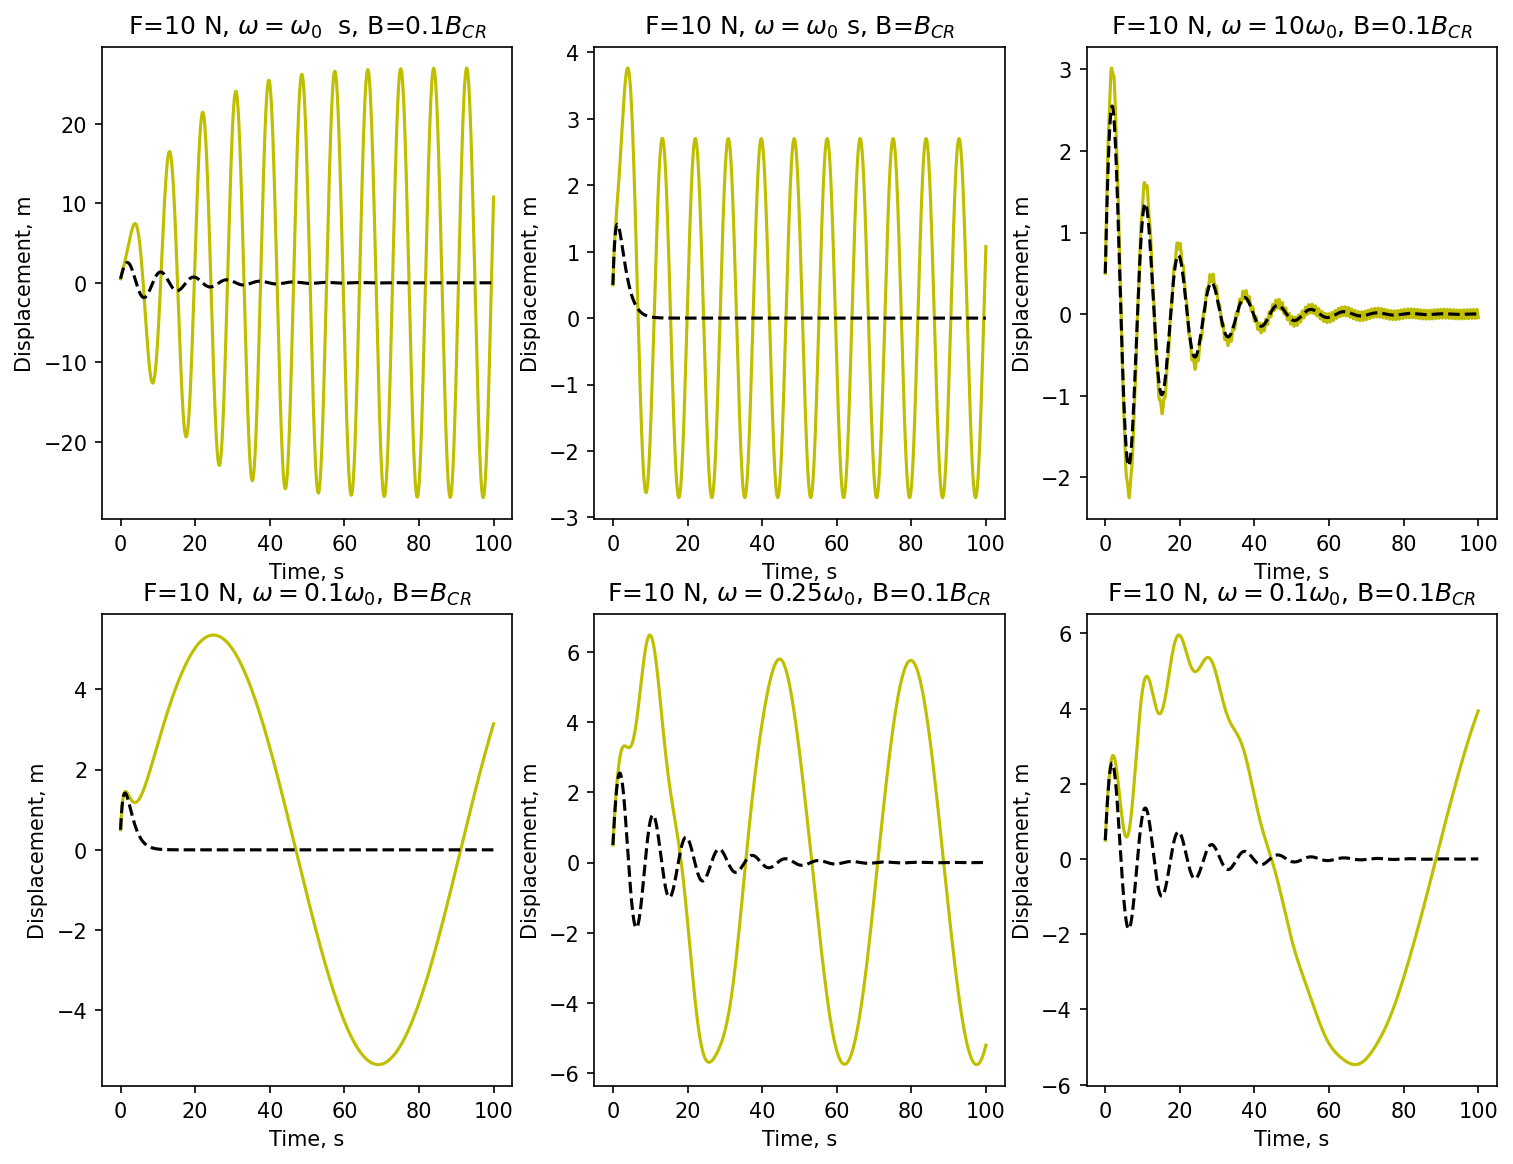

In [22]:
### Setting the initial conditions 
h = 0.005
B = 0.1*B_CR
F = 10
X_0 = 0.5
V_0 = 2
omega_0 = np.sqrt(K/M) # Rad/s, natural frequency of the system
time = np.linspace(0, 100, int(100/h))
### Solving the unforced case for the time period
y_ana = analytic(B, time)[0].real

### Configuring a figure to compare forced oscillation at different frequencies
fig,axs = plt.subplots(2,3)
fig.set_size_inches(12, 9)

### Plot of driving frequency matching the natural frequency of the system
axs[0, 0].set_title('F=10 N, $\omega = \omega_0$  s, B=0.1$B_{CR}$')
pos = forced_verlet(h, B, sin_force(F, omega_0, time), X_0, V_0, time)[0]
axs[0, 0].plot(time, pos, 'y')
axs[0, 0].plot(time, y_ana, 'k--')
axs[0, 0].set_xlabel("Time, s")
axs[0, 0].set_ylabel("Displacement, m")

### Plot of driving frequency matching the natural frequencu at critical damping.
axs[0, 1].set_title('F=10 N, $\omega = \omega_0$ s, B=$B_{CR}$')
pos = forced_verlet(h, B_CR, sin_force(F, omega_0, time), X_0, V_0, time)[0]
axs[0, 1].plot(time, pos, 'y')
axs[0, 1].plot(time, verlet(h, B_CR, time)[0], 'k--')
axs[0, 1].set_xlabel("Time, s")
axs[0, 1].set_ylabel("Displacement, m")

### Plot of driving frequency 5 times the natural frequency
axs[0, 2].set_title('F=10 N, $\omega = 10\omega_0$, B=0.1$B_{CR}$')
pos = forced_verlet(h, B, sin_force(F, omega_0*10, time), X_0, V_0, time)[0]
axs[0, 2].plot(time, pos, 'y')
axs[0, 2].plot(time, y_ana, 'k--')
axs[0, 2].set_xlabel("Time, s")
axs[0, 2].set_ylabel("Displacement, m")

### Plot of driving frequency at half the natural frequency
axs[1, 0].set_title('F=10 N, $\omega = 0.1\omega_0$, B=$B_{CR}$')
pos = forced_verlet(h, B_CR, sin_force(F, omega_0*0.1, time), X_0, V_0, time)[0]
axs[1, 0].plot(time, pos, 'y')
axs[1, 0].plot(time, verlet(h, B_CR, time)[0], 'k--')
axs[1, 0].set_xlabel("Time, s")
axs[1, 0].set_ylabel("Displacement, m")

### Plot of driving frequency at a tenth of the natural frequency, at critical damping
axs[1, 1].set_title('F=10 N, $\omega = 0.25\omega_0$, B=0.1$B_{CR}$')
pos = forced_verlet(h, B, sin_force(F, omega_0*0.25, time), X_0, V_0, time)[0]
axs[1, 1].plot(time, pos, 'y')
axs[1, 1].plot(time, y_ana, 'k--')
axs[1, 1].set_xlabel("Time, s")
axs[1, 1].set_ylabel("Displacement, m")

### Plot of driving frequency at a tenth of the natural frequency
axs[1, 2].set_title('F=10 N, $\omega = 0.1\omega_0$, B=0.1$B_{CR}$')
pos = forced_verlet(h, B, sin_force(F, omega_0*0.1, time), X_0, V_0, time)[0]
axs[1, 2].plot(time, pos, 'y')
axs[1, 2].plot(time, y_ana, 'k--')
axs[1, 2].set_xlabel("Time, s")
axs[1, 2].set_ylabel("Displacement, m")

At low damping, the resonant frequency is approximately the natural frequency, and as can be seen the greatest amplitude occurs when the frequencies are equal. Even still, at critical damping the system still responds significantly to the driving frequency, though lower frequencies will have a larger amplitude of oscillation. As frequency increases further, the effect of the force diminishes and the response tends to appearing the same as an unforced system. 

However, at very low frequencies the system responds significantly, although not close to the extent as near $\omega_0$. In this case, the oscillator approximately takes the form of the of driving force and, after the transient period, appear to have about the same amplitude of oscillation.

## Resonance

The damping ratio $\zeta = \frac{\gamma}{2\sqrt{mk}}$ can be used to find the resonant frequency of a system by the relation $\omega_r = \omega_0 \sqrt{1 - 2\zeta^2}$. At low damping this can be approximated to be the natural frequency, however as damping is increased this becomes less appropriate. This section seeks to examine the change in amplitude response with damping and with change in angular frequency.

In [23]:
def amplitude(freq, B , F):
    ### Creating a function to give amplitude values of oscillator for a given frequency
    return (F/M)/(np.sqrt((K/M-freq**2)**2 + (freq**2)*((B/M)**2)))

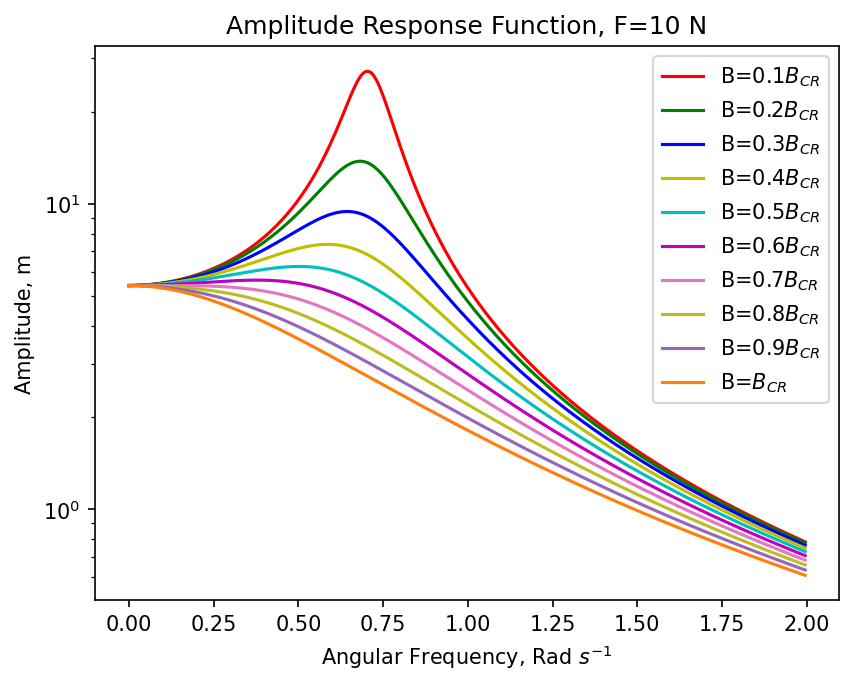

In [24]:
### Defining the parameters to examine
F=10
ang_freq=np.arange(0,2, 0.005)
coeffs = np.arange(0.1,1.1,0.1)

### Plotting amplitude against angular frequency for a series of damping values to aid resonance analysis
plt.title("Amplitude Response Function, F=10 N")
for i, value in enumerate(coeffs):
    plt.plot(ang_freq, amplitude(ang_freq, value*B_CR, F), colours[i])
plt.yscale("log")
plt.ylabel("Amplitude, m")
plt.xlabel("Angular Frequency, Rad $s^{-1}$")
plt.legend(["B=0.1$B_{CR}$","B=0.2$B_{CR}$","B=0.3$B_{CR}$","B=0.4$B_{CR}$","B=0.5$B_{CR}$","B=0.6$B_{CR}$"
            ,"B=0.7$B_{CR}$","B=0.8$B_{CR}$","B=0.9$B_{CR}$","B=$B_{CR}$",])

This response function shows corroborates very well with the observations made previously. In particular, that at high frequencies the amplitude will tend to zero, and at low frequencies the amplitude tends to a constant. Further more, it agrees that when damping is critical, lower frequencies will have an increased amplitude response.

Using the resonant frequency, the response of a system damped  at 0.5$B_CR$ will be examined. Frequencies about the resonant will be used, and also the natural frequency. This level of damping was chosen because, using the graph above, there is a significant difference between these two frequencies, but the damping is not so great that the difference in peak height is indistinguishable.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

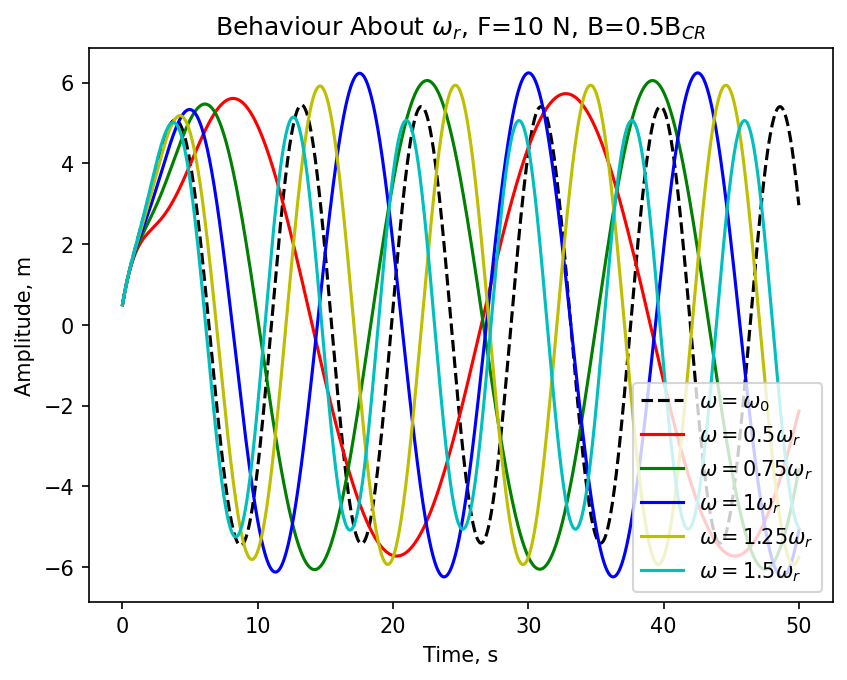

In [25]:
### Defining the parameters to be used for analysis
B = 0.5*B_CR
h = 0.005
F = 10
X_0 = 0.5
V_0 = 2
omega_r = np.sqrt(K/M)*np.sqrt(1-2*(B/B_CR)**2)
coeffs = np.linspace(0.5,1.5,5)
time = np.linspace(0, 50, int(50/h))

### Configuring the plot
plt.title("Behaviour About $\omega_r$, F=10 N, B=0.5B$_{CR}$")
### Plotting the driving force at the natural frequency
pos = forced_verlet(h, B, sin_force(F, omega_0, time), X_0, V_0, time)[0] 
plt.plot(time, pos, "k--")
### Creating plots about the resonant frequency for comparison
for i, value in enumerate(coeffs): 
    pos = forced_verlet(h, B, sin_force(F, omega_r*value, time), X_0, V_0, time)[0]
    plt.plot(time, pos, colours[i])
plt.xlabel("Time, s")
plt.ylabel("Amplitude, m")
plt.legend(["$\omega = \omega_0$", "$\omega = 0.5\omega_r$","$\omega = 0.75\omega_r$","$\omega = 1\omega_r$"
            ,"$\omega = 1.25\omega_r$","$\omega = 1.5\omega_r$"], loc="lower right")  
plt.tight_layout

As was expected from the amplitude response graph, resonance of this system occurs at a significantly lower frequency than its natural frequency, as $\omega_0 \approx 1.4\omega_r$. Also predicted was that the amplitude response curve is not symmetric about the peak. By observation this is corroborable, as frequencies 25% lower than $\omega_r$ are noticably higher than those 25% above.

## Animating this Response

This 

In [26]:
def response_animation(n):
    ### Function defining the state of the system in each frame    
    y1 = forced1[n]
    y2 = forced2[n]
    y3 = forced3[n]
    y4 = forced4[n]
    y5 = forced5[n]
    y6 = forced6[n]
        
    line1.set_data(np.linspace(0.5,0.6,2), y1)
    line2.set_data(np.linspace(0.7,0.8,2), y2)
    line3.set_data(np.linspace(0.9,1,2), y3)
    line4.set_data(np.linspace(1.1,1.2,2), y4)
    line5.set_data(np.linspace(1.3,1.4,2), y5)
    line6.set_data(np.linspace(1.5,1.6,2), y6)

    return (line1),(line2),(line3),(line4),(line5),(line6),

In [27]:
%%capture
### Defining the initial conditions of the system
B = 0.5*B_CR
h = 0.005
F = 10
X_0 = 0.5
V_0 = 2
omega_r = np.sqrt(K/M)*np.sqrt(1-2*(B/B_CR)**2)
coeffs = np.linspace(0.5,1.5,5)
time = np.linspace(0, 60, int(60/h))

### Creating a figure for animation & defining each of the oscillator colours
fig = plt.figure()
ax = plt.subplot(1,1,1) 
ax.set_xlim(0,2)
ax.set_ylim(-8,8)
ax.set_xlabel("Oscillator Position, m")
ax.set_ylabel("Displacement, m")
ax.set_title('Behaviour About $\omega_r$, F=10 N, B=0.5B$_{CR}$')
line1, = ax.plot([], [], colours[0], lw=2)
line2, = ax.plot([], [], colours[1], lw=2)
line3, = ax.plot([], [], colours[2], lw=2)
line4, = ax.plot([], [], colours[3], lw=2)
line5, = ax.plot([], [], colours[4], lw=2)
line6, = ax.plot([], [], colours[5], lw=2)
fig.legend(["$\omega = \omega_0$", "$\omega = 0.5\omega_r$","$\omega = 0.75\omega_r$","$\omega = 1\omega_r$"
            ,"$\omega = 1.25\omega_r$","$\omega = 1.5\omega_r$"])

### Creating arrays of position data for each frequency
forced1 = forced_verlet(h, B, sin_force(F, omega_0, time), X_0, V_0, time)[0][::25]
forced2 = forced_verlet(h, B, sin_force(F, omega_r*coeffs[0], time), X_0, V_0, time)[0][::25]
forced3 = forced_verlet(h, B, sin_force(F, omega_r*coeffs[1], time), X_0, V_0, time)[0][::25]
forced4 = forced_verlet(h, B, sin_force(F, omega_r*coeffs[2], time), X_0, V_0, time)[0][::25]
forced5 = forced_verlet(h, B, sin_force(F, omega_r*coeffs[3], time), X_0, V_0, time)[0][::25]
forced6 = forced_verlet(h, B, sin_force(F, omega_r*coeffs[4], time), X_0, V_0, time)[0][::25]

anim = animation.FuncAnimation(fig, response_animation, frames=len(time[::25]), interval=20, blit=True)

In [28]:
rc('animation', html='html5')
anim

# Case (C): Drag Forces

In this section of the project, the effect of drag forces on a harmonic oscillator will be considered in a simple case. As this is a relatively slow moving mass, the drag equation was used to find the drag force, and will be compared to the analytic result in order to judge how these methods would differ from experimental results, and how to account for it. The mass of the oscillating object was used to find a corresponding volume , assuming the mass to be made of iron. From there, the cross-sectional area of a series of objects with known drag coefficients can be found, and the difference in rate of decay be compared to find which shape is optimal to minimise the impact of drag.

As drag is dependent on a series of parameters including instantaneous velocity, the Verlet function is first updated.

In [29]:
### Defining the Verlet method to include an external force, and taking initial conditions as arguements for convenience
def drag_verlet(h, b, p, A, C_Drag, x0, v0, t):
    nsteps = len(t) # Number of h steps within the set period
    ### Defining the position & velocity arrays, as well as initial conditions
    x = np.zeros(nsteps)
    v = np.zeros(nsteps)
    x[0] = x0 # These are now variables of the function, so a series of applied forces can be found
    v[0] = v0 # by chaining the functions together. 
    
    ### This solution is not self starting, so the Euler-Cromer method is used to find the second term
    a = - (K/M)*x[0] - (b/M)*v[0] + (0.5*(v[0]**2)*p*C_Drag*A)/M       
    v[1] = v[0] + h*a
    x[1] = x[0] + h*v[1]
    
    ### The constants for this function are defined, and the verlet method is applied for the time period
    C = 2*M + b*h     
    D = 2*(2*M - K*(h**2))/C
    E = (b*h - 2*M)/C
    F = (2*(h**2))/C
    for i in range(nsteps - 2):
        x[i+2] = D*x[i+1] + E*x[i] + F*(0.5*(v[i+1]**2)*p*C_Drag*A)
        v[i+2] = (D*x[i+2] + E*x[i+1] + F*(0.5*(v[i+1]**2)*p*C_Drag*A) - x[i+1])/(2*h)

    return x, v

Text(0, 0.5, 'Displacement, m')

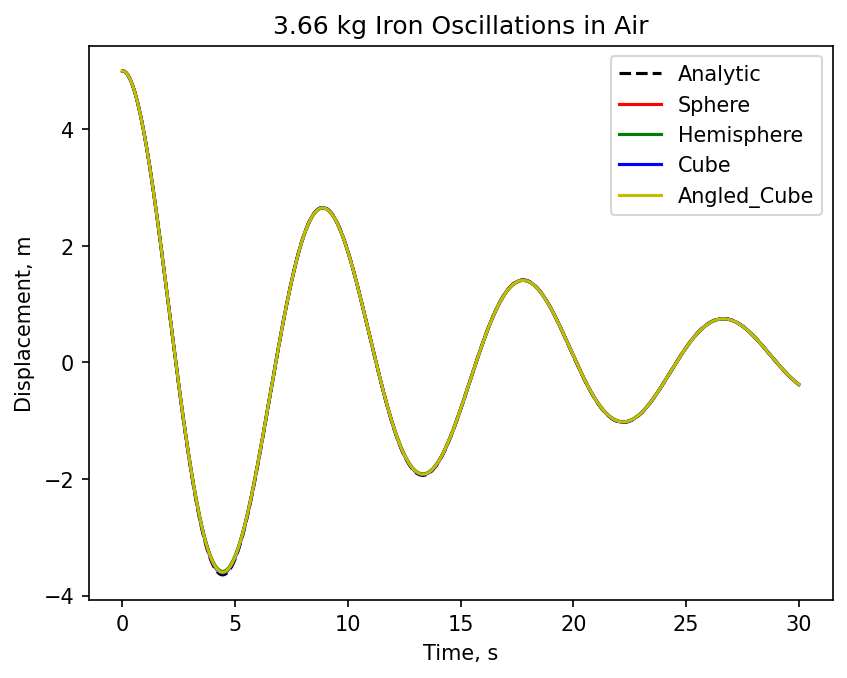

In [30]:
### Defining the initial conditions
B = 0.1*B_CR
h = 0.005
X_0 = 5
V_0 = 0
time = np.linspace(0,30,int(30/h))
air_density = 1.205 # kg/m^3

### Determining the volume of the mass given a density, and finding the cross-sectional area for a series of shapes
density = 7870 # kg/m^3, Iron
volume = M/density
radius_sphere = np.cbrt((3*volume)/(4*np.pi))
radius_hemisphere = np.cbrt((3*volume)/(2*np.pi))
area_sphere = np.pi*radius_sphere**2
area_hemisphere = np.pi*radius_hemisphere**2
area_cube = volume**(2/3)
area_angled_cube = np.sqrt(2)*volume**(2/3)
area_array = ([area_sphere, area_hemisphere, area_cube, area_angled_cube])

### Defining the drag coefficients for each shape
C_sphere = 0.47 # Sphere
C_hemisphere = 0.42 # Hemisphere
C_cube = 1.05 # Cube
C_angled_cube = 0.8 # Cube, face angled at 45 degrees to motion
C_array = ([C_sphere, C_hemisphere, C_cube, C_angled_cube]) # Creating an array to iterate the plotting

### Plotting the oscillations of each shape & the analytic solution
y_ana = analytic(B, time)[0].real
plt.plot(time, y_ana, "k--")
for i, C in enumerate(C_array):
    pos, vel = drag_verlet(h, B, air_density, area_array[i] , value, X_0, V_0, time)
    plt.plot(time, pos, colours[i])
plt.title('{} kg Iron Oscillations in Air'.format(M))
plt.legend(["Analytic","Sphere", "Hemisphere", "Cube", "Angled_Cube"])
plt.xlabel("Time, s")
plt.ylabel("Displacement, m")

From above, it is clear that for the  mass and spring constant considered in the rest of this project, drag would have a negligible impact on experimental results compared to the numerical solutions. This is most likely due to the small surface area corresponding to a ball of iron of this mass. 

For completeness, an object 10 times as massive will next be considered to accentuate the difference in drag experienced, so the optimal shape can never the less be determined out of the four shapes chosen.

Text(0, 0.5, 'Displacement, m')

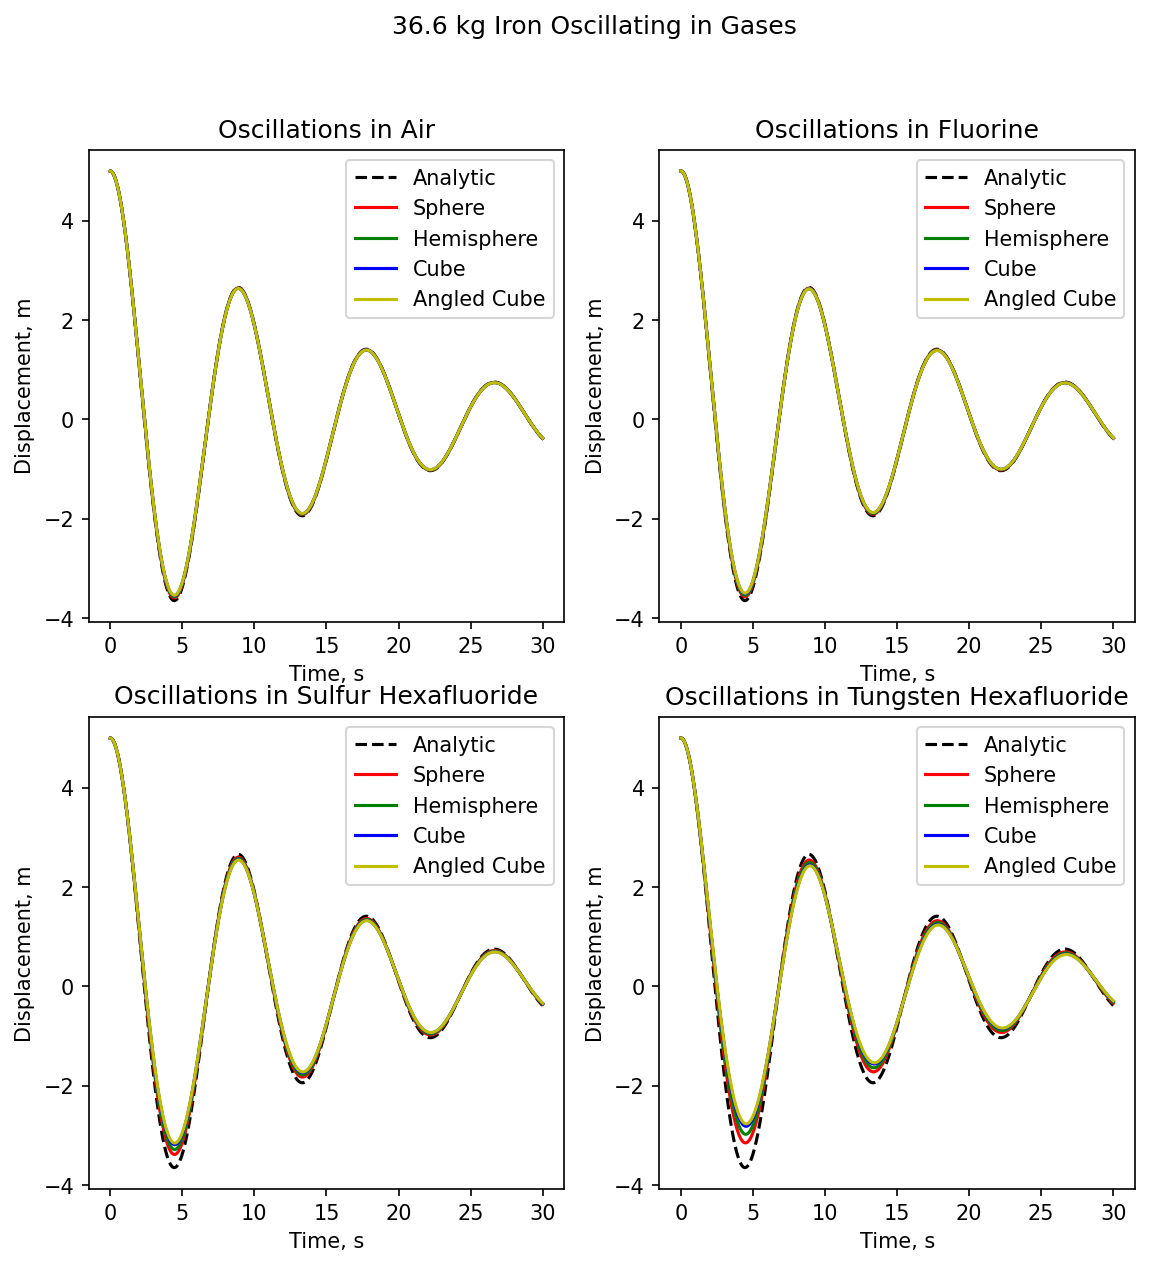

In [31]:
### Defining the initial conditions
B = 0.1*B_CR
h = 0.005
X_0 = 5
V_0 = 0
time = np.linspace(0,30,int(30/h))

### Determining the volume of the mass given a density, and finding the cross-sectional area for a series of shapes
density = 7870 # kg/m^3, Iron
volume = 10*M/density
radius_sphere = np.cbrt((3*volume)/(4*np.pi))
radius_hemisphere = np.cbrt((3*volume)/(2*np.pi))
area_sphere = np.pi*radius_sphere**2
area_hemisphere = np.pi*radius_hemisphere**2
area_cube = volume**(2/3)
area_angled_cube = np.sqrt(2)*volume**(2/3)
area_array = ([area_sphere, area_hemisphere, area_cube, area_angled_cube])


### Defining the drag coefficients for each shape
C_sphere = 0.47 # Sphere
C_hemisphere = 0.42 # Hemisphere
C_cube = 1.05 # Cube
C_angled_cube = 0.8 # Cube, face angled at 45 degrees to motion
C_array = ([C_sphere, C_hemisphere, C_cube, C_angled_cube]) # Creating an array to iterate the plotting

### Defining the densities of a series of gases
air_density = 1.205 # kg/m^3
fluorine_density = 1.7 # kg/m^3
sulfur_hexafluoride_density = 6.17  # kg/m^3
tungsten_hexafluoride_density = 12.4 # kg/m^3

### Creating a 2x2 set of plots to plot the oscillations of each shape in a series of gases
fig,axs = plt.subplots(2,2)
fig.set_size_inches(9, 9)
fig.suptitle("{} kg Iron Oscillating in Gases".format(10*M))
y_ana = analytic(B, time)[0].real # Defining the analytic value for the system

axs[0,0].set_title('Oscillations in Air')
axs[0,0].plot(time, y_ana, "k--")

for i, value in enumerate(C_array):   
    pos, vel = drag_verlet(h, B, air_density, area_array[i] , value, X_0, V_0, time)
    axs[0,0].plot(time, pos, colours[i])
axs[0,0].legend(["Analytic","Sphere", "Hemisphere", "Cube", "Angled Cube"])
axs[0,0].set_xlabel("Time, s")
axs[0,0].set_ylabel("Displacement, m")

axs[0,1].set_title('Oscillations in Fluorine')
axs[0,1].plot(time, y_ana, "k--")
for i, value in enumerate(C_array):   
    pos, vel = drag_verlet(h, B, fluorine_density, area_array[i] , value, X_0, V_0, time)
    axs[0,1].plot(time, pos, colours[i])
axs[0,1].legend(["Analytic","Sphere", "Hemisphere", "Cube", "Angled Cube"])
axs[0,1].set_xlabel("Time, s")
axs[0,1].set_ylabel("Displacement, m")

axs[1,0].set_title('Oscillations in Sulfur Hexafluoride')
axs[1,0].plot(time, y_ana, "k--")
for i, value in enumerate(C_array):   
    pos, vel = drag_verlet(h, B, sulfur_hexafluoride_density, area_array[i] , value, X_0, V_0, time)
    axs[1,0].plot(time, pos, colours[i])
axs[1,0].legend(["Analytic","Sphere", "Hemisphere", "Cube", "Angled Cube"])
axs[1,0].set_xlabel("Time, s")
axs[1,0].set_ylabel("Displacement, m")

axs[1,1].set_title('Oscillations in Tungsten Hexafluoride')
axs[1,1].plot(time, y_ana, "k--")
for i, value in enumerate(C_array):   
    pos, vel = drag_verlet(h, B, tungsten_hexafluoride_density, area_array[i] , value, X_0, V_0, time)
    axs[1,1].plot(time, pos, colours[i])
axs[1,1].legend(["Analytic","Sphere", "Hemisphere", "Cube", "Angled Cube"])
axs[1,1].set_xlabel("Time, s")
axs[1,1].set_ylabel("Displacement, m")

Particularly clear in the extremely dense hexafluoride gases, a spherical mass is the optimal of the given shapes for minimising the impact of drag upon results. However, even at 36 kg, the drag experienced by a sphere of iron oscillating in air is negligible when compared to the analytic result, meaning for most oscillation experiments, air resistance can be neglected.